In [1]:
from dustmaps.config import config
config.reset()

In [2]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp

from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [3]:
import sys
import importlib


# Clear the module from cache
if "local_GRBafterglows_metric" in sys.modules:
    del sys.modules["local_GRBafterglows_metric"]

# Re-import and reload the updated module
import local_GRBafterglows_metric
importlib.reload(local_GRBafterglows_metric)

# Import updated classes and functions from the refactored module
from local_GRBafterglows_metric import (
    GRBAfterglowLC,
    GRBAfterglowDetectMetric,
    generateGRBPopSlicer,
    GRBAfterglowSpecTriggerableMetric,
    GRBAfterglowCharacterizeMetric,
    GRBAfterglowColorEvolveMetric,
    GRBAfterglowHistoricalMatchMetric
)



# Confirm path
print(local_GRBafterglows_metric.__file__)

# Filter utility: select events within t_start and t_end range
def filter_population_by_time(slicer, t_start, t_end):
    peak_times = slicer.slice_points['peak_time']
    mask = (peak_times >= t_start) & (peak_times < t_end)
    ra = slicer.slice_points['ra'][mask]
    dec = slicer.slice_points['dec'][mask]
    print("Filtered Dec sample (rad):", dec[:10])
    new_slicer = metric_bundles.UserPointsSlicer(ra=ra, dec=dec, badval=0)
    new_slicer.slice_points = {k: v[mask] for k, v in slicer.slice_points.items()}
    return new_slicer


/Users/fbianco/Transient_Metrics_Hub/Multi_Transient_Metrics_Hub/GRBafterglows/local_GRBafterglows_metric.py


/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric local_GRBafterglows_metric.BaseGRBAfterglowMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric local_GRBafterglows_metric.GRBAfterglowDetectMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric local_GRBafterglows_metric.GRBAfterglowCharacterizeMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/opt/anacond

In [32]:
#all configs
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
rate_density = 1e-6
rate_str = f"rd{rate_density:.0e}".replace("-", "m")  # Example: 1e-8 to rd1e-8
filters = ['u', 'g', 'r', 'i', 'z', 'y']
grbs_dir = f"GRBafterglows_fixedpop_detectonly/{rate_str}"
grb_templates_file = "GRBAfterglow_templates.pkl"
grb_pop_file = os.path.join(grbs_dir, f"GRB_population_fixedpop_10yr_{rate_str}.pkl")
dmin, dmax = 10, 1000
gal_lat_cut = None
os.makedirs(grbs_dir, exist_ok=True)
db_dir = "../"


## All 10 years

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB population from GRBafterglows_fixedpop_detectonly/rd1em06/GRB_population_fixedpop_10yr_rd1em06.pkl

--- Running four_roll_v4.3.1_10yrs ---


/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_6432/1706729689.py:45: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 41761 simulated GRB events, Rubin detected 11400 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.0 ± 0.0 filters.


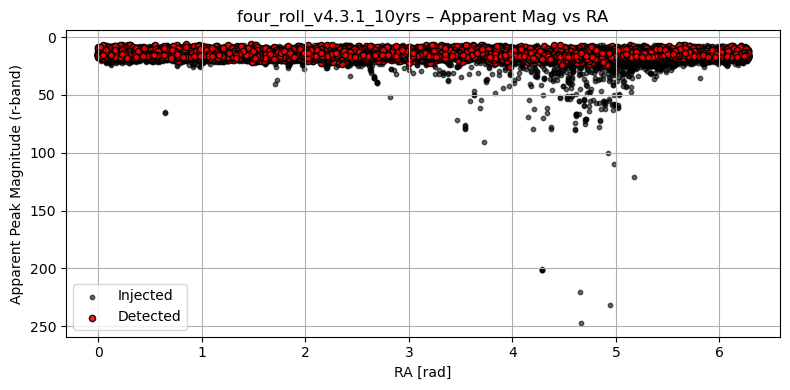

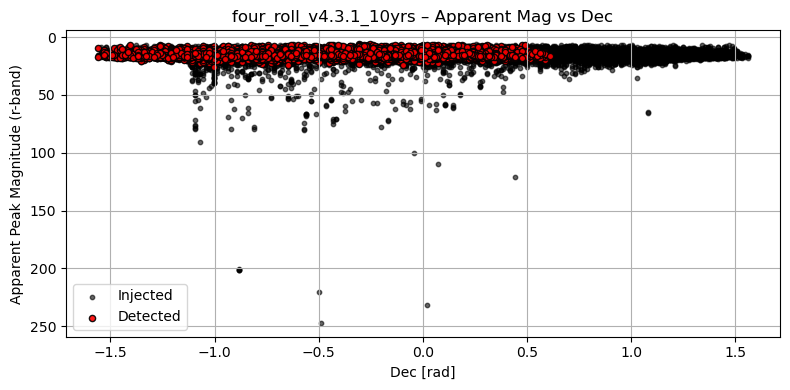

[DEBUG] Detected RA, Dec: 180.73, -43.41
[DEBUG] Detected RA, Dec: 18.28, -23.97
[DEBUG] Detected RA, Dec: 342.42, 1.19
[DEBUG] Detected RA, Dec: 243.62, -68.68
[DEBUG] Detected RA, Dec: 296.72, 7.78
[DEBUG] Detected RA, Dec: 148.36, 19.47
[DEBUG] Detected RA, Dec: 73.83, -9.59
[DEBUG] Detected RA, Dec: 66.09, 20.11
[DEBUG] Detected RA, Dec: 147.66, -16.33
[DEBUG] Detected RA, Dec: 27.35, -52.03
[DEBUG] Detected RA, Dec: 176.48, -9.59
[DEBUG] Detected RA, Dec: 307.97, -22.67
[DEBUG] Detected RA, Dec: 236.25, 8.99
[DEBUG] Detected RA, Dec: 55.55, -1.19


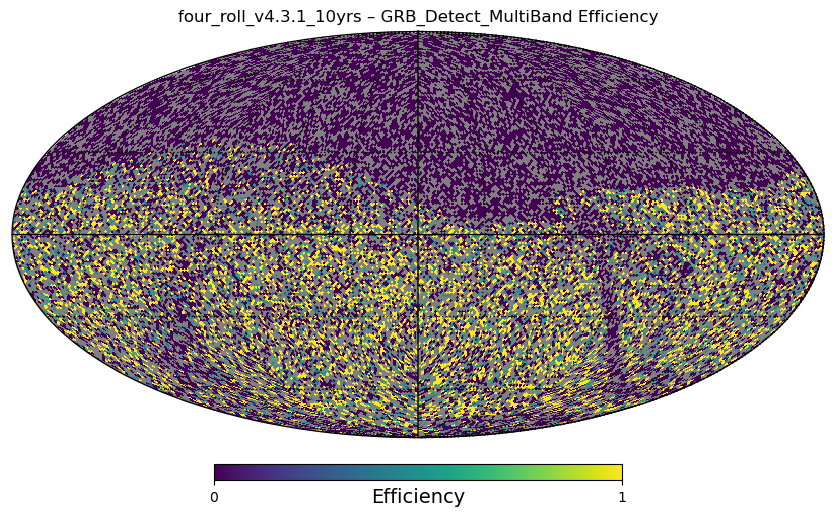

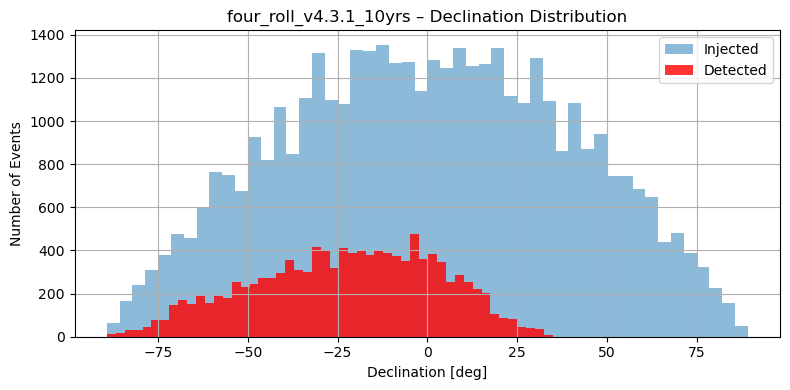

[DEBUG] Detected RA, Dec: 226.41, -12.64
[DEBUG] Detected RA, Dec: 279.00, -48.92
[DEBUG] Detected RA, Dec: 124.45, -10.81
[DEBUG] Detected RA, Dec: 34.45, -35.69
[DEBUG] Detected RA, Dec: 180.70, 1.19
[DEBUG] Detected RA, Dec: 357.55, -48.92
[DEBUG] Detected RA, Dec: 111.80, -32.80
[DEBUG] Detected RA, Dec: 46.41, -21.38
[DEBUG] Detected RA, Dec: 331.17, -2.39


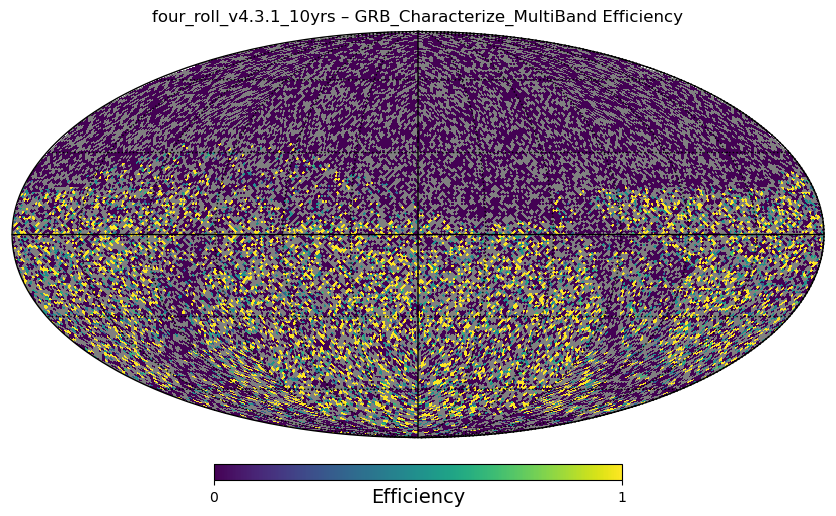

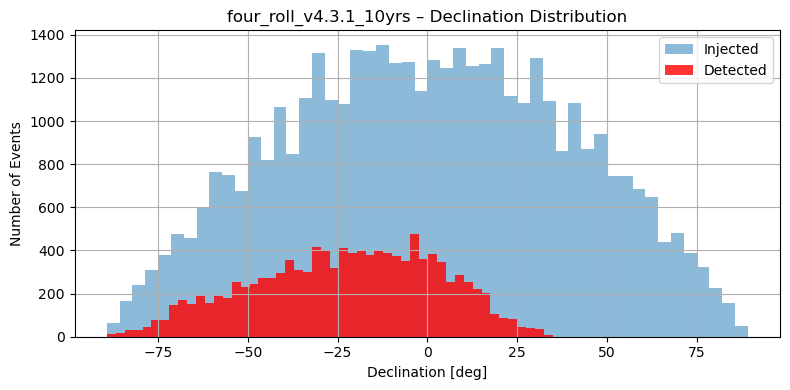

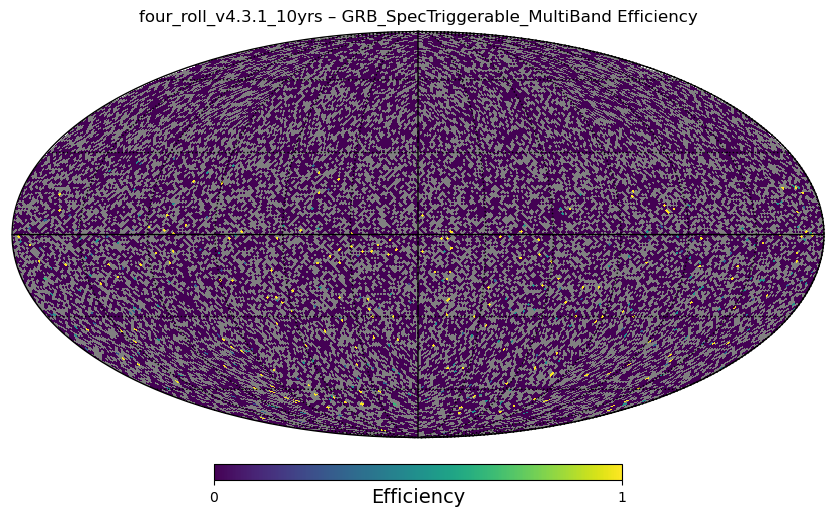

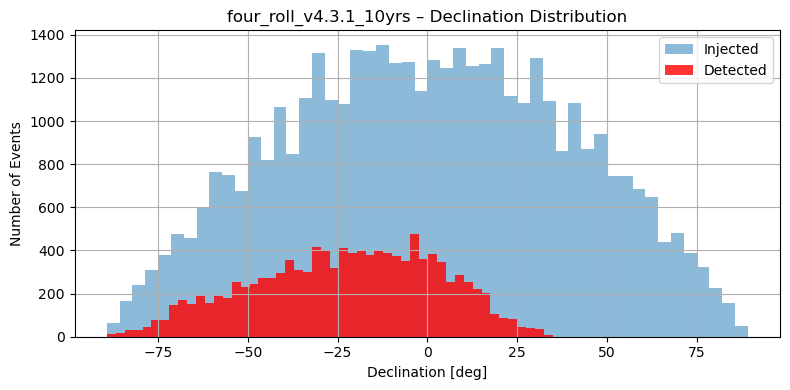

[DEBUG] Detected RA, Dec: 184.22, -41.01
[DEBUG] Detected RA, Dec: 44.30, -13.25
[DEBUG] Detected RA, Dec: 125.86, -8.39
[DEBUG] Detected RA, Dec: 73.83, -12.02
[DEBUG] Detected RA, Dec: 354.38, -21.38


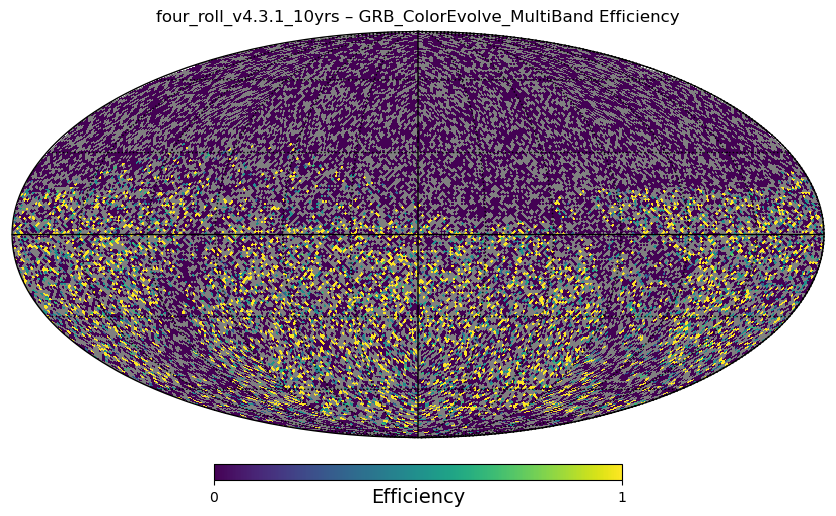

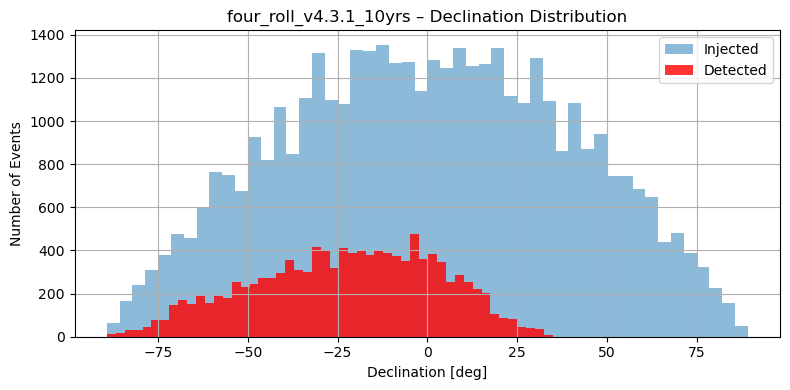

[DEBUG] Detected RA, Dec: 347.46, -44.20
[DEBUG] Detected RA, Dec: 278.27, -53.57
[DEBUG] Detected RA, Dec: 147.66, 15.09
[DEBUG] Detected RA, Dec: 194.77, 0.00
[DEBUG] Detected RA, Dec: 132.89, 1.19
[DEBUG] Detected RA, Dec: 205.31, 11.42
[DEBUG] Detected RA, Dec: 223.59, -18.84
[DEBUG] Detected RA, Dec: 36.47, -46.57
[DEBUG] Detected RA, Dec: 234.14, 3.58
[DEBUG] Detected RA, Dec: 68.20, -7.18
[DEBUG] Detected RA, Dec: 39.38, -17.58
[DEBUG] Detected RA, Dec: 298.12, -27.95
[DEBUG] Detected RA, Dec: 290.25, -75.34
[DEBUG] Detected RA, Dec: 211.72, -44.20
[DEBUG] Detected RA, Dec: 262.27, -24.62
[DEBUG] Detected RA, Dec: 66.80, 2.39


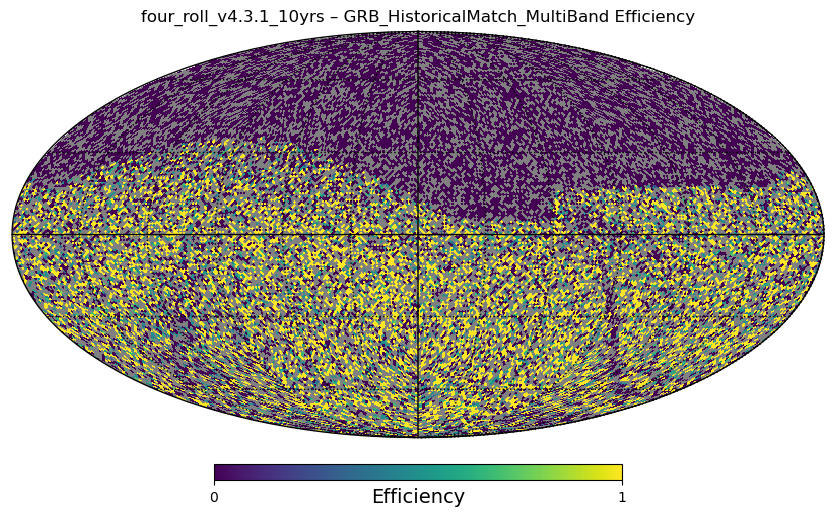

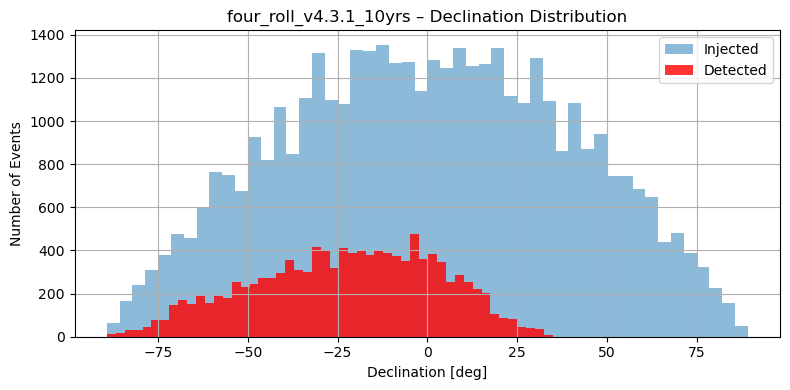


--- Running baseline_v4.3.1_10yrs ---


/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_6432/1706729689.py:45: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 41761 simulated GRB events, Rubin detected 11456 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.0 ± 0.0 filters.


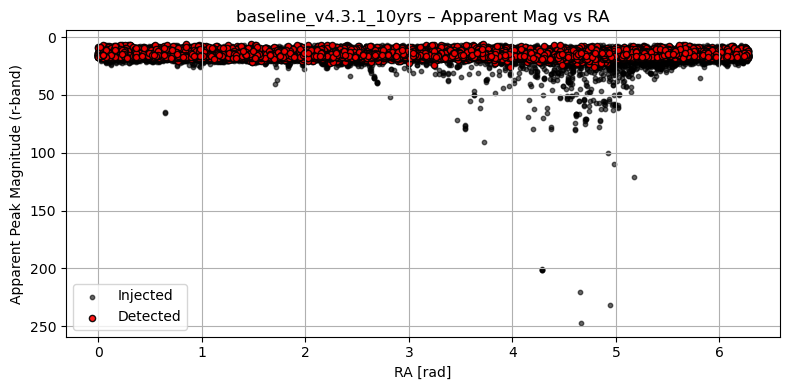

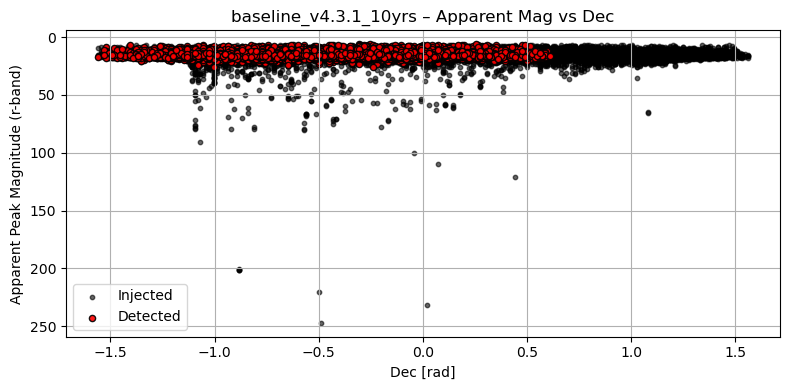

[DEBUG] Detected RA, Dec: 45.00, -7.78
[DEBUG] Detected RA, Dec: 331.17, -41.81
[DEBUG] Detected RA, Dec: 2.11, -14.48
[DEBUG] Detected RA, Dec: 279.84, -66.44
[DEBUG] Detected RA, Dec: 120.23, -2.39
[DEBUG] Detected RA, Dec: 3.52, -31.39
[DEBUG] Detected RA, Dec: 50.62, -11.42


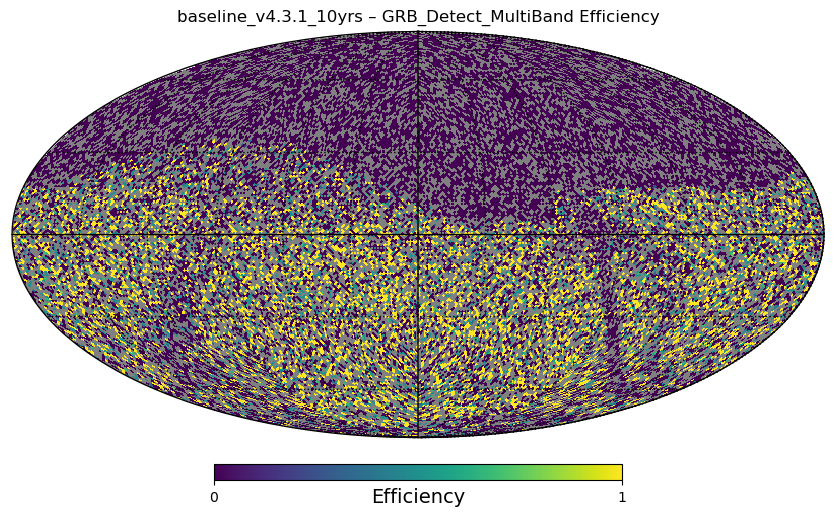

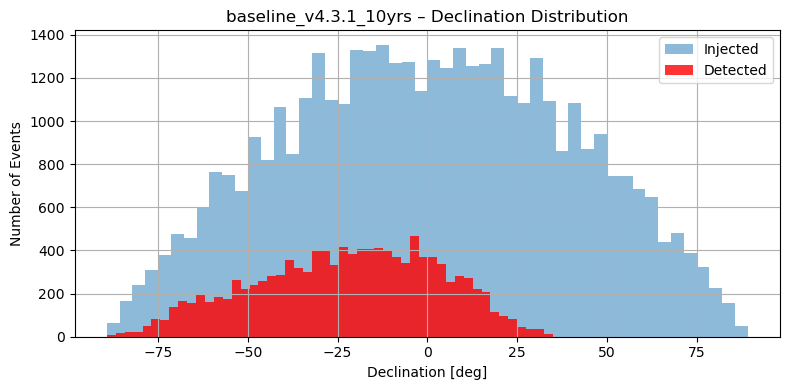

[DEBUG] Detected RA, Dec: 358.59, -10.20
[DEBUG] Detected RA, Dec: 122.34, -11.42
[DEBUG] Detected RA, Dec: 243.46, -61.19
[DEBUG] Detected RA, Dec: 143.44, 11.42
[DEBUG] Detected RA, Dec: 142.71, -64.20
[DEBUG] Detected RA, Dec: 159.61, 8.39
[DEBUG] Detected RA, Dec: 298.12, 8.99
[DEBUG] Detected RA, Dec: 15.47, -26.61
[DEBUG] Detected RA, Dec: 222.19, -22.67
[DEBUG] Detected RA, Dec: 170.16, -8.99
[DEBUG] Detected RA, Dec: 170.86, -31.39
[DEBUG] Detected RA, Dec: 120.94, -27.95
[DEBUG] Detected RA, Dec: 1.41, -2.99
[DEBUG] Detected RA, Dec: 262.97, -41.01
[DEBUG] Detected RA, Dec: 162.42, 8.39
[DEBUG] Detected RA, Dec: 208.83, 8.39


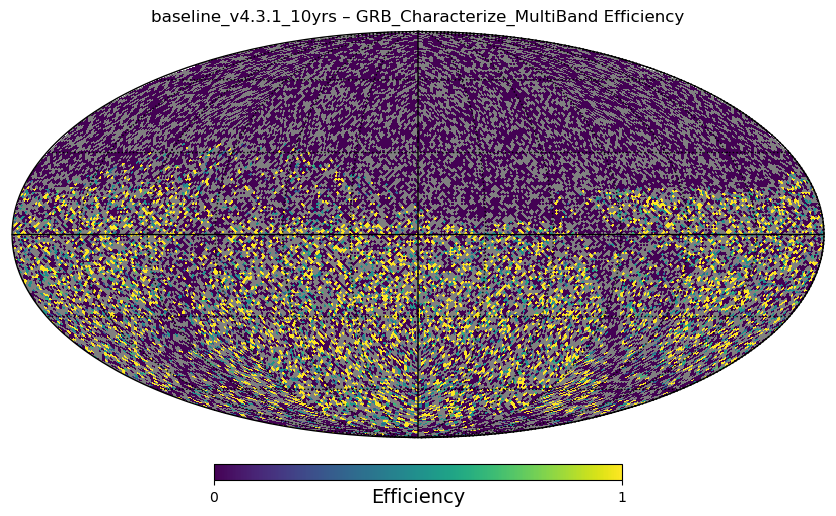

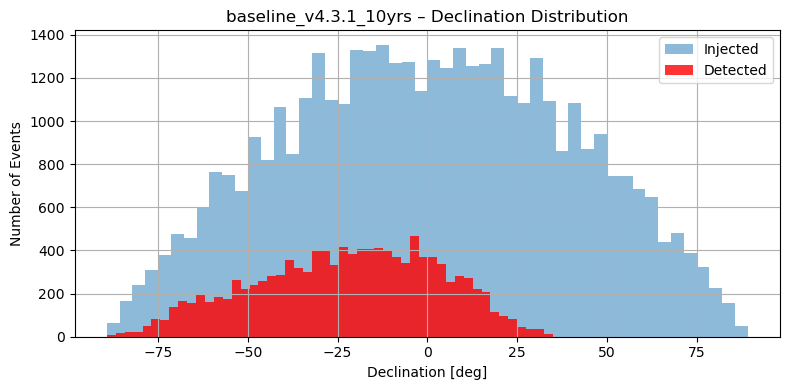

[DEBUG] Detected RA, Dec: 115.82, -44.20


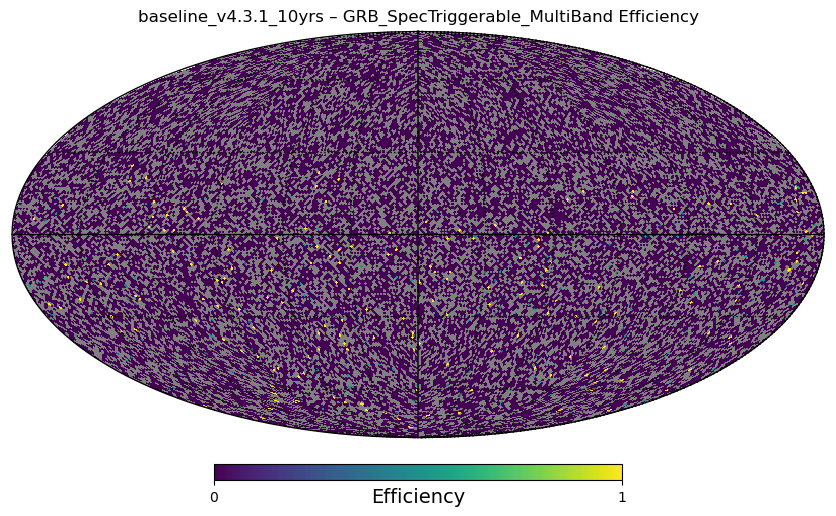

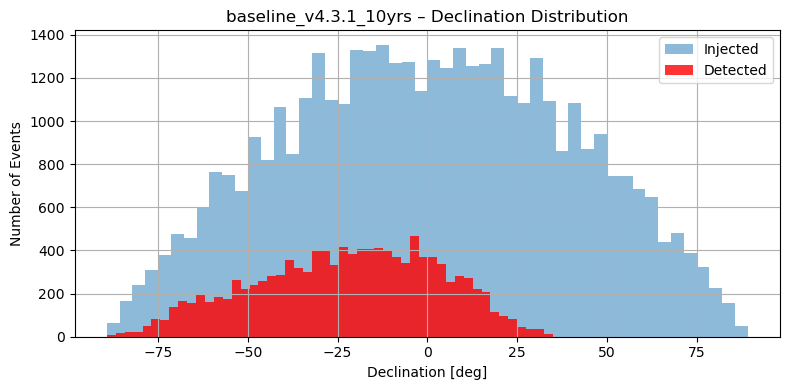

[DEBUG] Detected RA, Dec: 283.36, -20.74
[DEBUG] Detected RA, Dec: 177.19, 2.99
[DEBUG] Detected RA, Dec: 203.20, -3.58
[DEBUG] Detected RA, Dec: 222.82, -43.41
[DEBUG] Detected RA, Dec: 31.64, 16.96


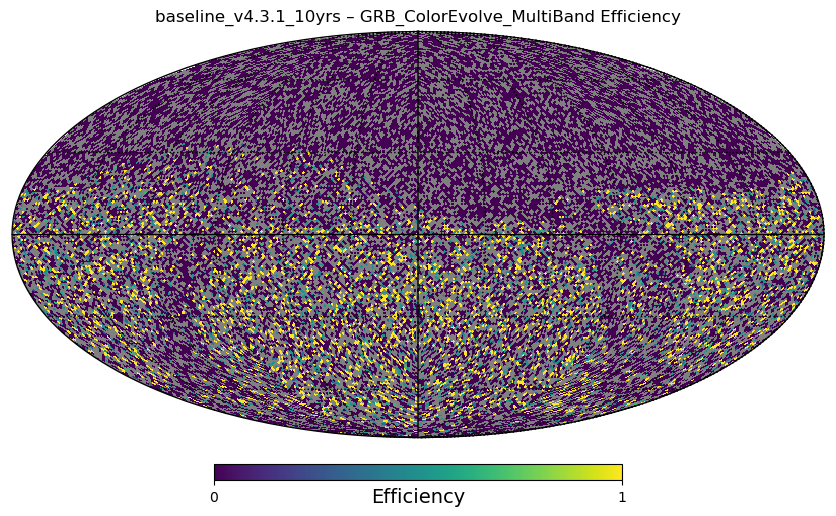

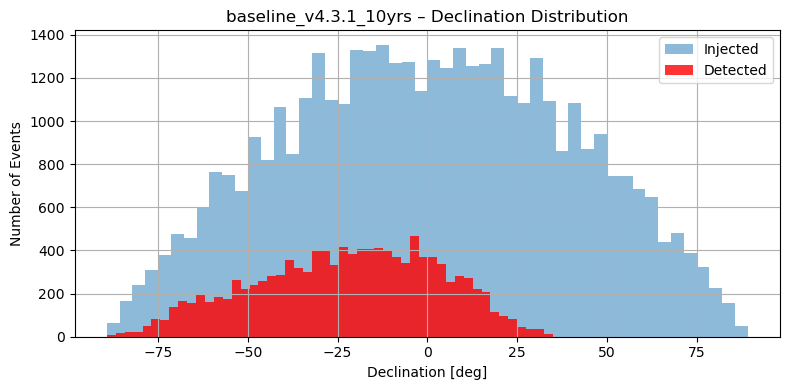

[DEBUG] Detected RA, Dec: 156.80, 1.19
[DEBUG] Detected RA, Dec: 262.97, 12.64
[DEBUG] Detected RA, Dec: 84.38, -1.79
[DEBUG] Detected RA, Dec: 9.20, -57.40
[DEBUG] Detected RA, Dec: 81.56, 7.78
[DEBUG] Detected RA, Dec: 35.16, -5.38
[DEBUG] Detected RA, Dec: 223.16, -53.57
[DEBUG] Detected RA, Dec: 246.80, 3.58
[DEBUG] Detected RA, Dec: 129.91, -50.48
[DEBUG] Detected RA, Dec: 287.58, -10.81
[DEBUG] Detected RA, Dec: 168.05, -34.23


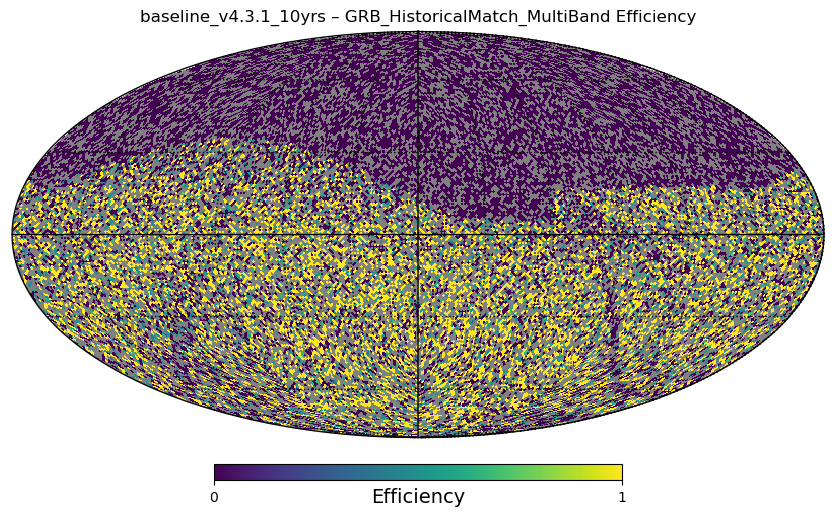

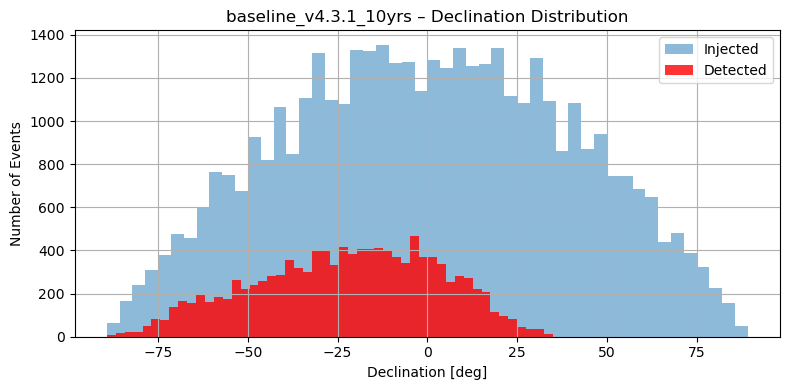

In [33]:
# ---- ALL 10 years Configuration ----
t_start = 1
t_end = 3652

# ---- Template Setup ----
if not os.path.exists(grb_templates_file):
    from local_GRBafterglows_metric import generateGRBAfterglowTemplates
    generateGRBAfterglowTemplates(save_to=grb_templates_file)
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

# ---- Population Setup ----
if not os.path.exists(grb_pop_file):
    slicer = generateGRBPopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut, rate_density=rate_density,
        save_to=grb_pop_file
    )
else:
    slicer = generateGRBPopSlicer(load_from=grb_pop_file)

n_events = len(slicer.slice_points['distance'])
first = 1
for cadence in cadences:
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)

    print(f"\n--- Running {cadence} ---")

    #### per filter metric here
    per_filter_metrics = OrderedDict()
    filters = ['all']
    for filt in filters:
        detect = GRBAfterglowDetectMetric(metricName=f"GRB_Detect_{filt}", #filter_include=[filt], 
                                         lc_model=shared_lc_model)
                    #GRBAfterglowSpecTriggerableMetric(metricName=f"GRB_Detect_{filt}", filter_include=[filt], 
                    #                      lc_model=shared_lc_model)
        per_filter_metrics[f"GRB_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')

    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()
    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])
    
    detected_mask = n_filters_detected_per_event >= 1
    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])

    print(f"Out of {n_events} simulated GRB events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


    # Plot: Apparent magnitude vs RA and Dec for one filter (e.g. 'r')
    filtername = 'r'
    ax1 = DustValues().ax1
    
    ras, decs, peak_mags, detected_flags = [], [], [], []
    
    for i in range(n_events):
        ra = slicer.slice_points['ra'][i]
        dec = slicer.slice_points['dec'][i]  # this is in radians already
        d = slicer.slice_points['distance'][i]
        ebv = slicer.slice_points['ebv'][i]
        file_indx = slicer.slice_points['file_indx'][i]
        
        m_peak = np.min(shared_lc_model.data[file_indx][filtername]['mag'])
        A = ax1[filtername] * ebv
        dm = 5 * np.log10(d * 1e6) - 5
        m_app = m_peak + dm + A
    
        ras.append(ra)
        decs.append(dec)
        peak_mags.append(m_app)
    
        detected = any(
            per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters
        )
        detected_flags.append(detected)

    # Plot: Apparent magnitude vs RA
    
    plt.figure(figsize=(8, 4))
    plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(ras)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("RA [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"{cadence} – Apparent Mag vs RA")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot: Apparent magnitude vs Dec
    plt.figure(figsize=(8, 4))
    plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(decs)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("Dec [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"{cadence} – Apparent Mag vs Dec")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

    # Optional: save summaries or plot
    outfile = os.path.join(grbs_dir, f"local_efficiency_{cadence}_GRBA.csv")
    with open(outfile, "w") as out:
        out.write("sid,n_filters_detected\n")
        for i in range(n_events):
            out.write(f"{i},{n_filters_detected_per_event[i]}\n")
    
    # Add multi-band metrics
    multi_metrics = [
        GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
    ]



    for metric in multi_metrics:
        mb_key = f"{runName}_{metric.__class__.__name__}"
        bundle = metric_bundles.MetricBundle(metric, slicer, '', file_root=mb_key, plot_funcs=[], summary_metrics=[metrics.SumMetric()])
        
        bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
        bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()
        if first:
            df = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            df["run"] = runName
            first = 0
        else:
            _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            _["run"] = runName            
            df = pd.concat([df, _])
        # Healpix plotting

        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        #print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            #if detected_flags[i] :
            if bundle.metric_values[i] == 1:
                if np.random.rand() < 0.001:
                    print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(eff_map, title=f"{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()

        plt.figure(figsize=(8, 4))

        plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
        plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
        plt.xlabel("Declination [deg]")
        plt.ylabel("Number of Events")
        plt.title(f"{cadence} – Declination Distribution")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        

In [34]:
df

Sum  \
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric     11400.0   
four_roll_v4.3.1_10yrs_GRBAfterglowCharacterize...   8077.0   
four_roll_v4.3.1_10yrs_GRBAfterglowSpecTriggera...    397.0   
four_roll_v4.3.1_10yrs_GRBAfterglowColorEvolveM...   6616.0   
four_roll_v4.3.1_10yrs_GRBAfterglowHistoricalMa...  15086.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric      11456.0   
baseline_v4.3.1_10yrs_GRBAfterglowCharacterizeM...   8246.0   
baseline_v4.3.1_10yrs_GRBAfterglowSpecTriggerab...    389.0   
baseline_v4.3.1_10yrs_GRBAfterglowColorEvolveMe...   6699.0   
baseline_v4.3.1_10yrs_GRBAfterglowHistoricalMat...  15160.0   

                                                                       run  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric     four_roll_v4.3.1_10yrs  
four_roll_v4.3.1_10yrs_GRBAfterglowCharacterize...  four_roll_v4.3.1_10yrs  
four_roll_v4.3.1_10yrs_GRBAfterglowSpecTriggera...  four_roll_v4.3.1_10yrs  
four_roll_v4.3.1_10yrs_GRBAfterglowColorEvolveM...  four_roll_v4.3.1_10yrs  
four_roll_v4.3.1_10yrs_GRBAfterglowHistoricalMa...  four_roll_v4.3.1_10yrs  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric       baseline_v4.3.1_10yrs  
baseline_v4.3.1_10yrs_GRBAfterglowCharacterizeM...   baseline_v4.3.1_10yrs  
baseline_v4.3.1_10yrs_GRBAfterglowSpecTriggerab...   baseline_v4.3.1_10yrs  
baseline_v4.3.1_10yrs_GRBAfterglowColorEvolveMe...   baseline_v4.3.1_10yrs  
baseline_v4.3.1_10yrs_GRBAfterglowHistoricalMat...   baseline_v4.3.1_10yrs

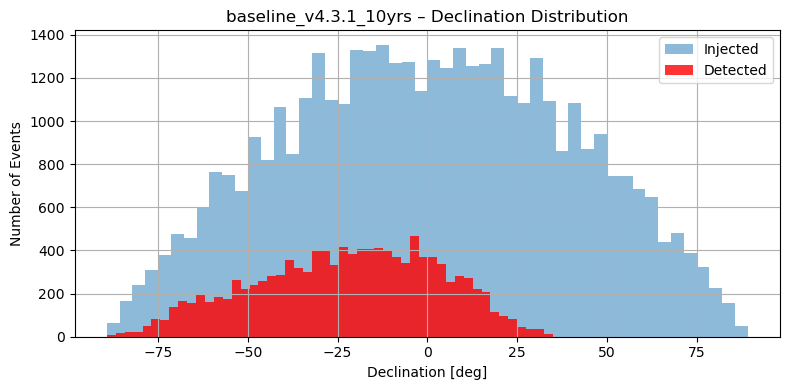

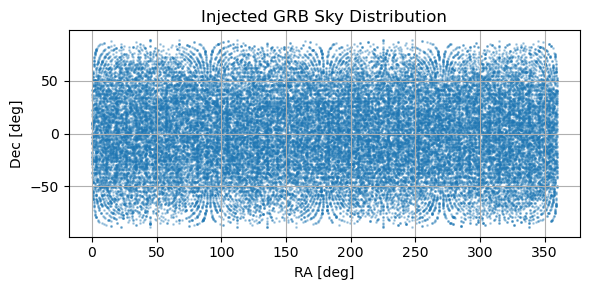

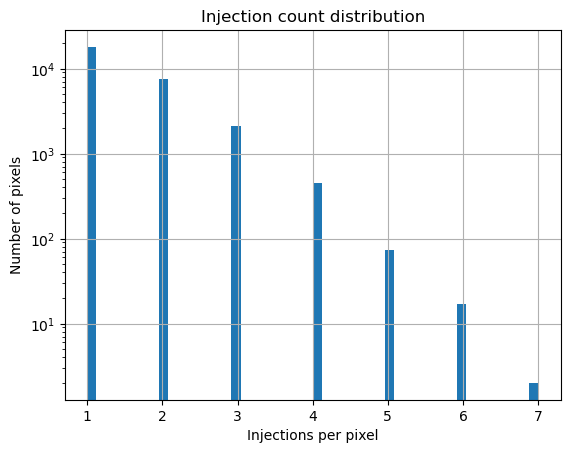

In [35]:
plt.figure(figsize=(8, 4))

plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
plt.xlabel("Declination [deg]")
plt.ylabel("Number of Events")
plt.title(f"{cadence} – Declination Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(np.degrees(ra_rad), np.degrees(dec_rad), s=1, alpha=0.3)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Injected GRB Sky Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.hist(injected_map[injected_map > 0], bins=50, log=True)
plt.xlabel("Injections per pixel")
plt.ylabel("Number of pixels")
plt.title("Injection count distribution")
plt.grid(True)
plt.show()



## Per year


=== Running GRB Detect-only for cadence: four_roll_v4.3.1_10yrs ===
[DEBUG] Detected RA, Dec: 165.23, -12.02


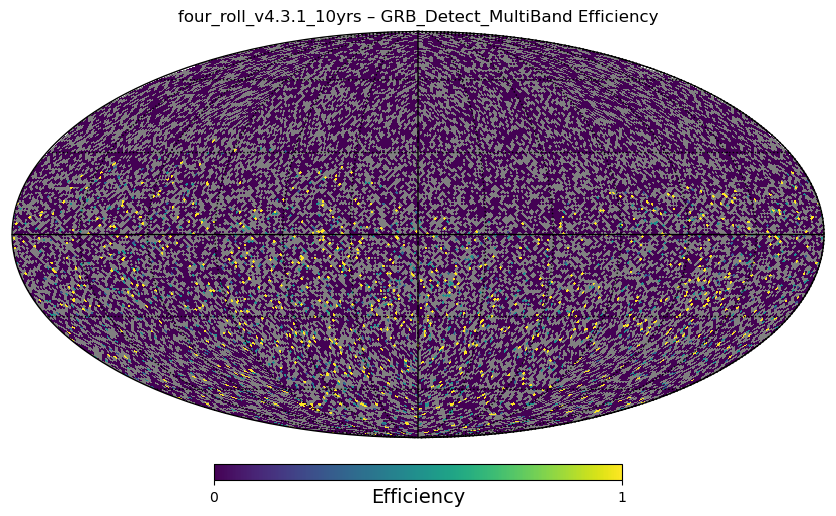

[DEBUG] Detected RA, Dec: 177.19, 6.58
[DEBUG] Detected RA, Dec: 157.13, -44.20
[DEBUG] Detected RA, Dec: 254.53, -34.95


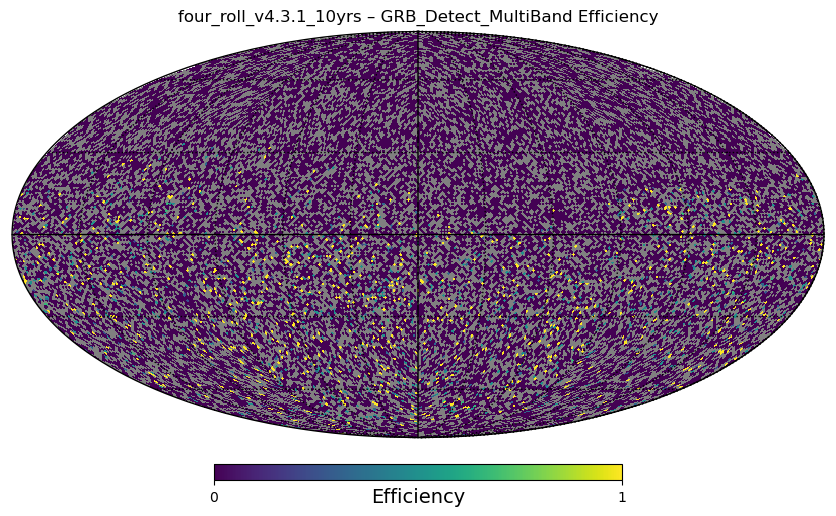

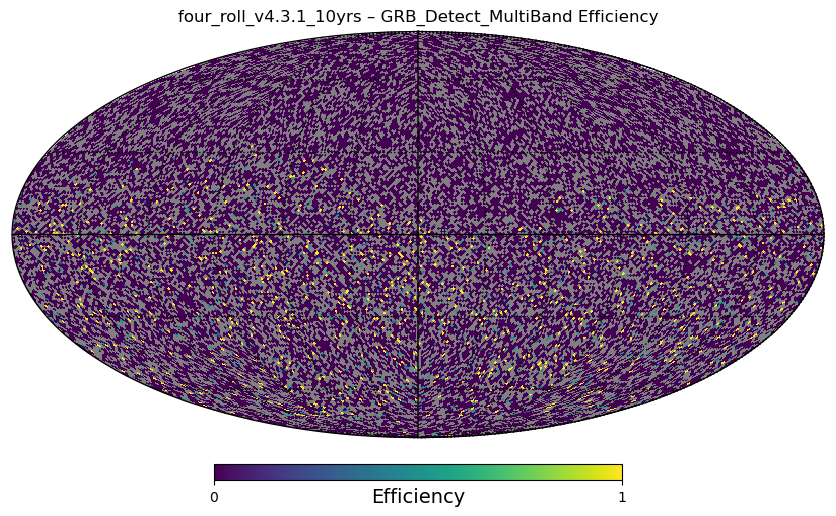

[DEBUG] Detected RA, Dec: 44.30, 16.96


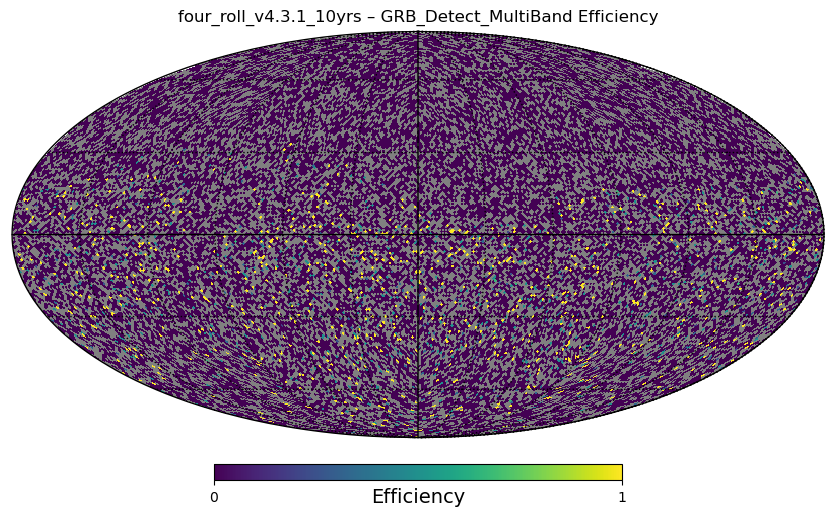

[DEBUG] Detected RA, Dec: 67.50, -33.51
[DEBUG] Detected RA, Dec: 32.34, -66.44
[DEBUG] Detected RA, Dec: 246.80, -25.94


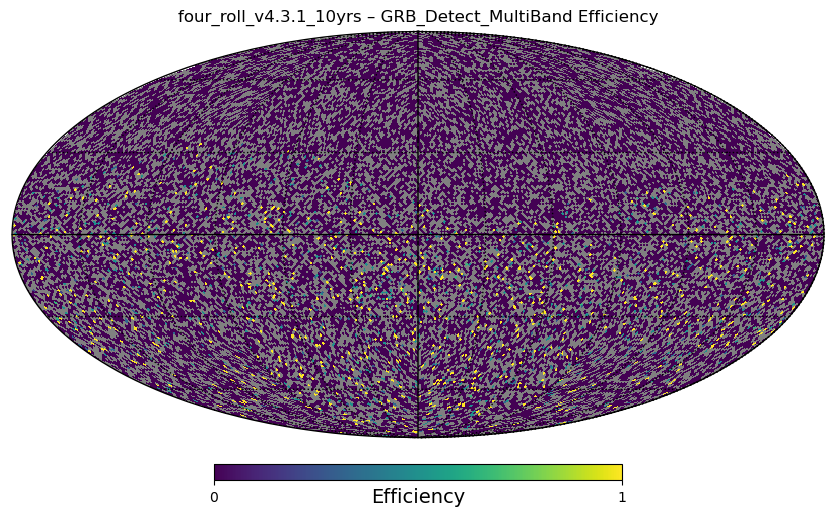

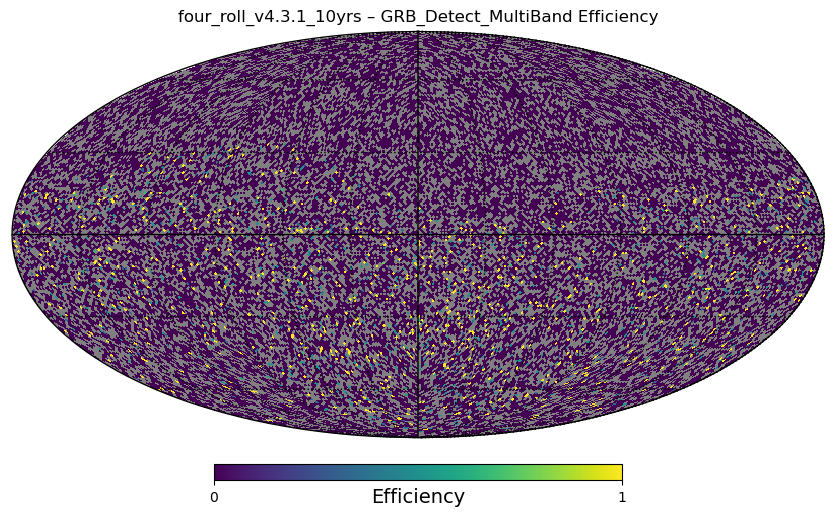

[DEBUG] Detected RA, Dec: 186.33, 14.48
[DEBUG] Detected RA, Dec: 177.19, -0.60


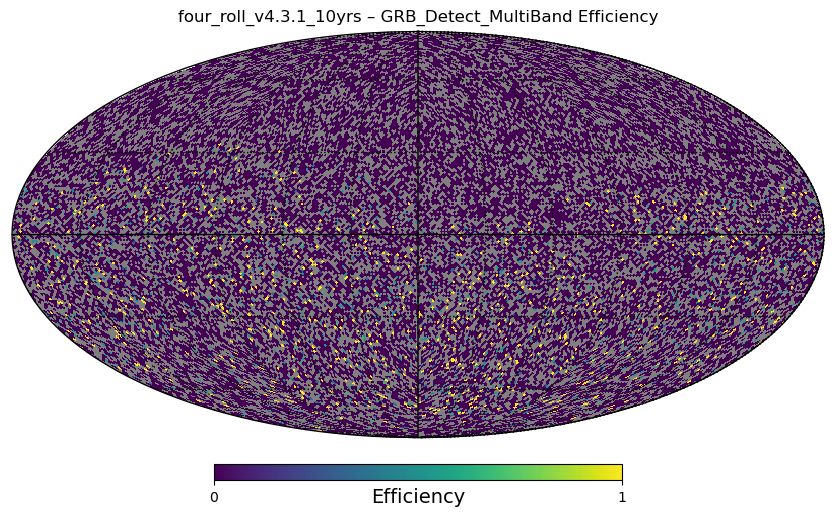

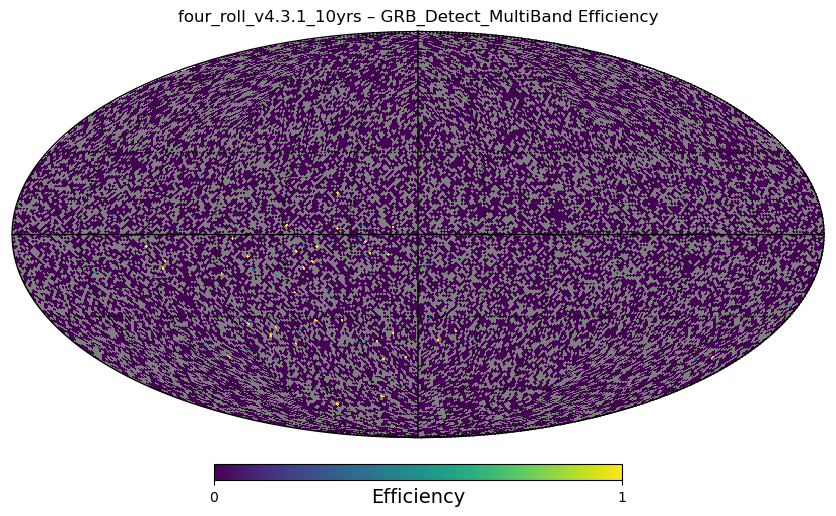

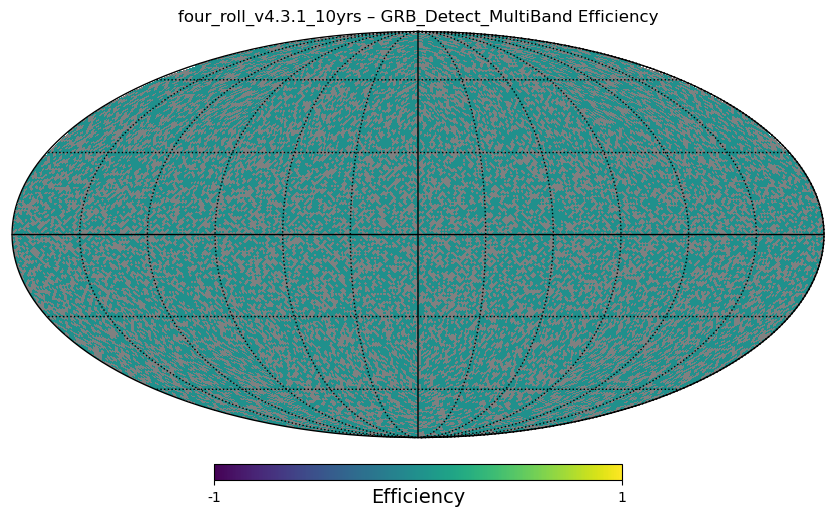

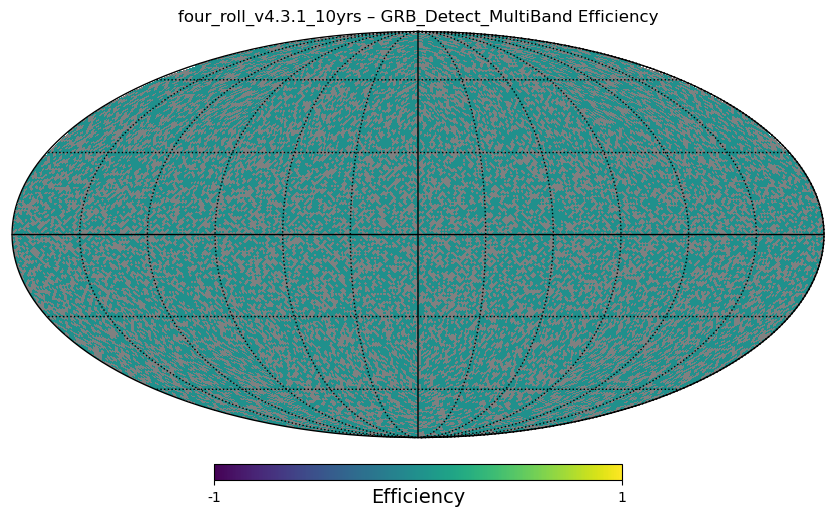


=== Running GRB Detect-only for cadence: baseline_v4.3.1_10yrs ===
[DEBUG] Detected RA, Dec: 201.80, -30.00
[DEBUG] Detected RA, Dec: 63.46, -61.19


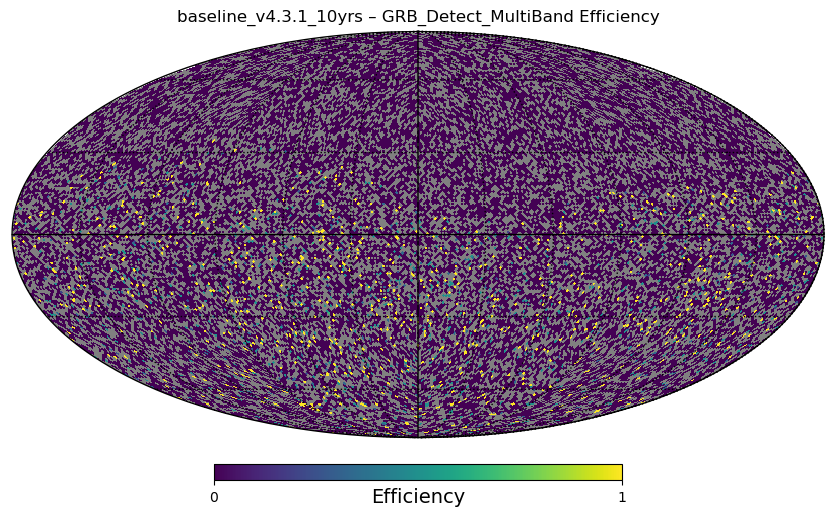

[DEBUG] Detected RA, Dec: 177.19, -20.11
[DEBUG] Detected RA, Dec: 71.02, -10.81
[DEBUG] Detected RA, Dec: 260.36, -58.92


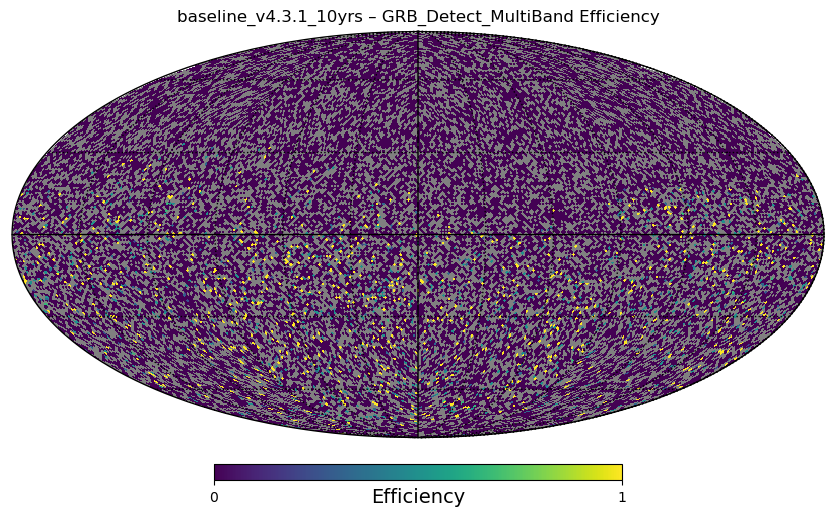

[DEBUG] Detected RA, Dec: 135.00, -12.64
[DEBUG] Detected RA, Dec: 358.59, -0.60


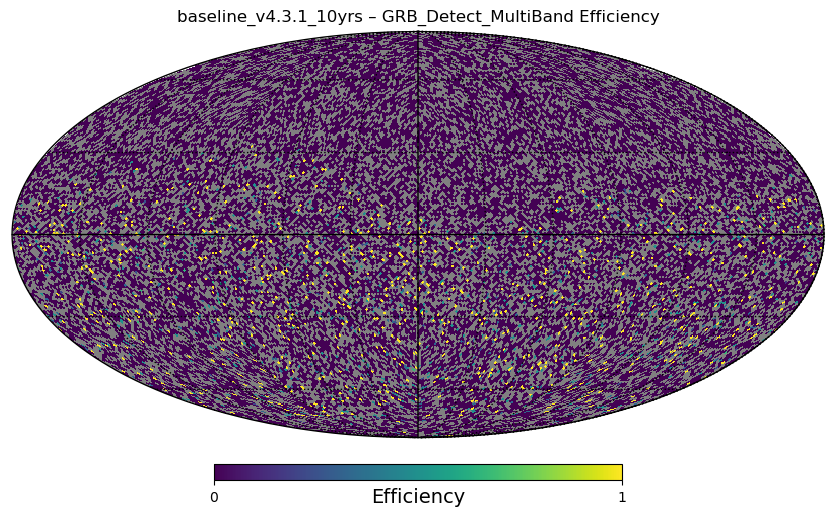

[DEBUG] Detected RA, Dec: 14.49, -45.78
[DEBUG] Detected RA, Dec: 213.75, -17.58


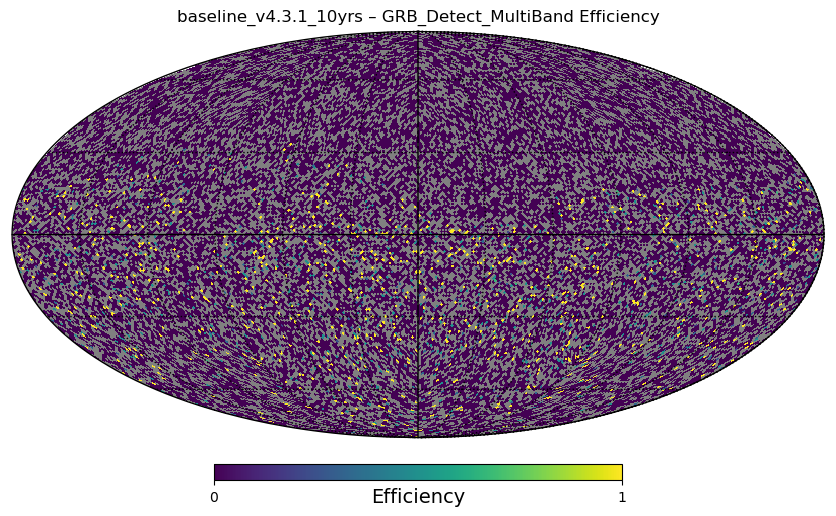

[DEBUG] Detected RA, Dec: 96.70, -55.11


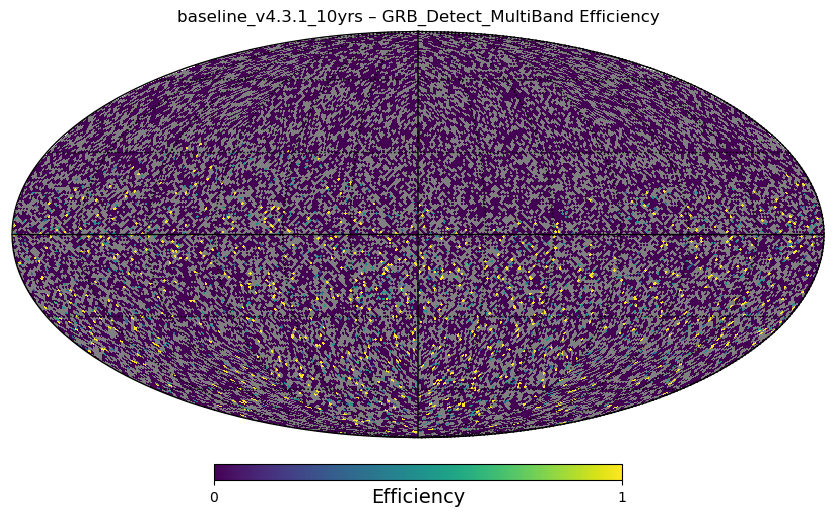

[DEBUG] Detected RA, Dec: 93.52, 4.78
[DEBUG] Detected RA, Dec: 52.03, -33.51
[DEBUG] Detected RA, Dec: 169.45, 7.18
[DEBUG] Detected RA, Dec: 345.94, -33.51
[DEBUG] Detected RA, Dec: 148.36, -28.63


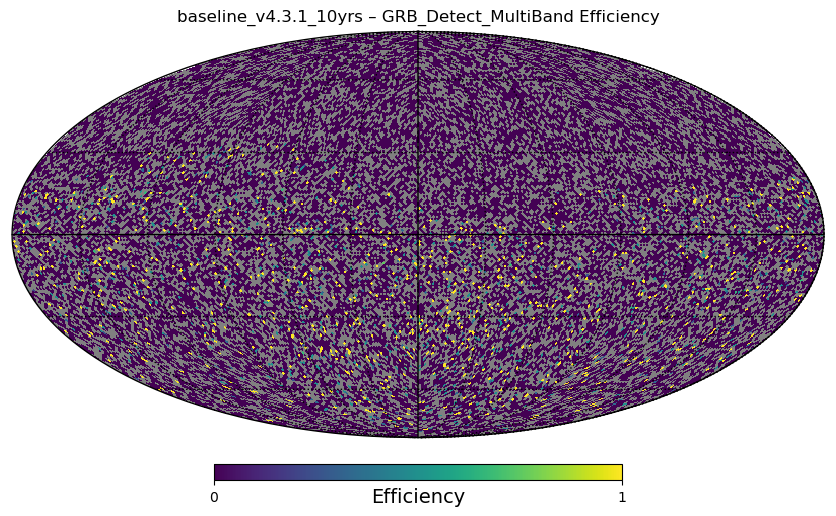

[DEBUG] Detected RA, Dec: 105.00, -47.36


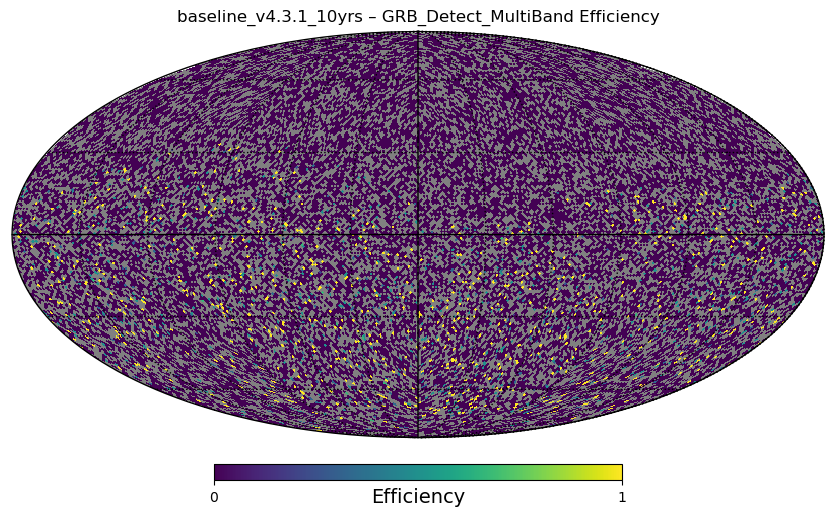

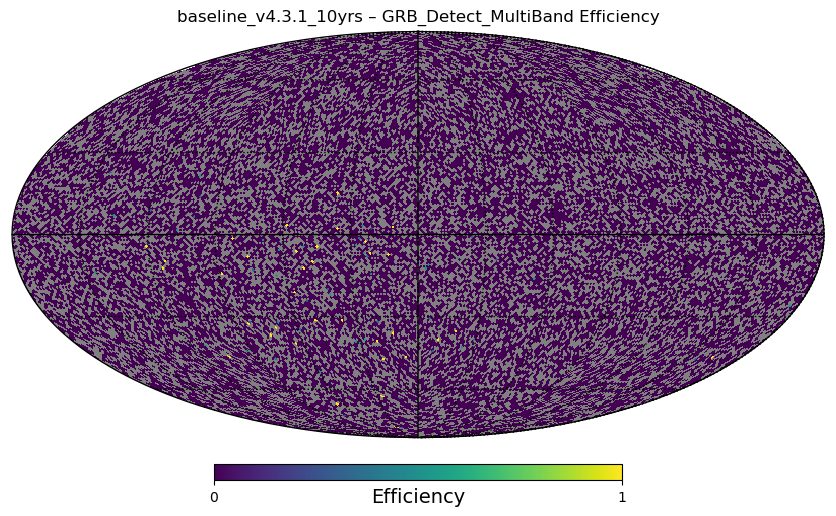

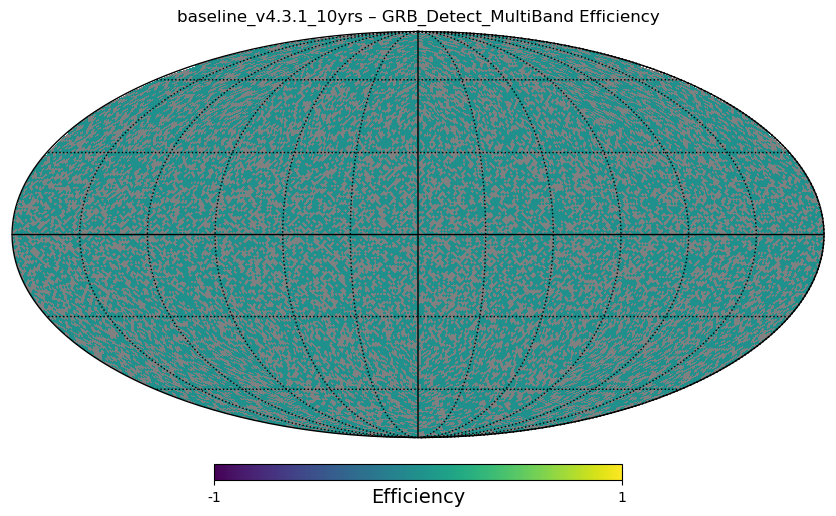

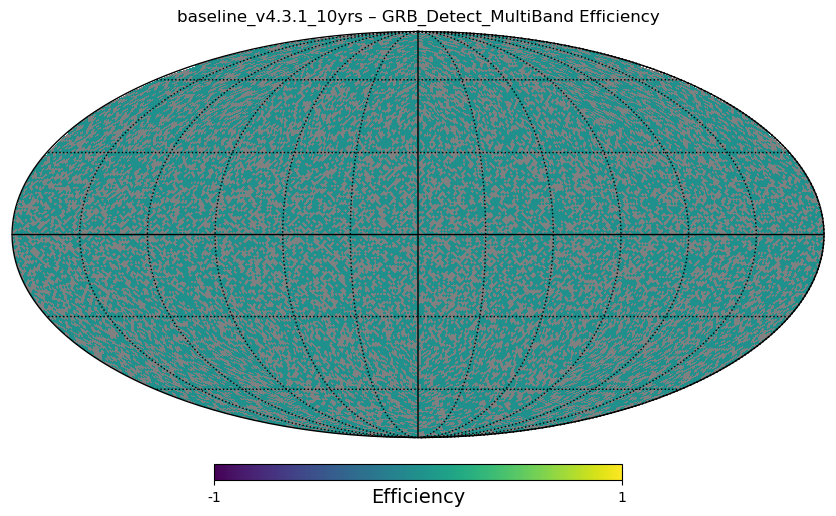

In [39]:
# ---- Per Year Configuration ----
year_intervals = [
    (1, 365), (365, 730), (730, 1095), (1095, 1460), (1460, 1825),
    (1825, 2190), (2190, 2555), (2555, 2920), (2920, 3285), (3285, 3652)
]
first = 1
for cadence in cadences:
    print(f"\n=== Running GRB Detect-only for cadence: {cadence} ===")
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"Metric_temp_{cadence}")
    opsdb = db_path

    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)
    
    for yr, (t0, t1) in enumerate(year_intervals):
        

        
        # Add multi-band metrics
        multi_metrics = [
            GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
        ]



        for metric in multi_metrics:
            mb_key = f"{runName}_{metric.__class__.__name__}"
            bundle = metric_bundles.MetricBundle(metric, slicer, f'night >= {t0} and night < {t1}', 
                                                 file_root=mb_key, plot_funcs=[], 
                                                 summary_metrics=[metrics.SumMetric()])
        
            bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
            bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
            bgroup.run_all()
            if first:
                df_yr = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
                df_yr["run"] = runName
                df_yr["year"] = yr
                first = 0
            else:
                _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
                _["run"] = runName  
                _["year"] = yr
                df_yr = pd.concat([df_yr, _])
            # Healpix plotting
    
            nside = slicer.nside if hasattr(slicer, 'nside') else 64
            npix = hp.nside2npix(nside)
            injected_map = np.zeros(npix)
            detected_map = np.zeros(npix)

            ra_rad = slicer.slice_points['ra']
            dec_rad = slicer.slice_points['dec']
            theta = 0.5 * np.pi - dec_rad
            phi = ra_rad
            pix_inds = hp.ang2pix(nside, theta, phi)

            #print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
            #print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
            #print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
            for i, pix in enumerate(pix_inds):
                injected_map[pix] += 1
                #if detected_flags[i] :
                if bundle.metric_values[i] == 1:
                    if np.random.rand() < 0.001:
                         print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                    detected_map[pix] += 1

            eff_map = np.zeros(npix)
            mask = injected_map > 0
            eff_map[mask] = detected_map[mask] / injected_map[mask]
            eff_map[~mask] = hp.UNSEEN

            hp.mollview(eff_map, title=f"{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
            hp.graticule()
            #plt.tight_layout()
            plt.show()

In [40]:
df_yr

Sum  \
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1776.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1866.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1713.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1614.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1653.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1684.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  1729.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric    85.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric     0.0   
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric     0.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1776.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1866.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1713.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1614.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1653.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1684.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric   1729.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric     85.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric      0.0   
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric      0.0   

                                                                    run  year  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     0  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     1  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     2  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     3  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     4  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     5  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     6  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     7  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     8  
four_roll_v4.3.1_10yrs_GRBAfterglowDetectMetric  four_roll_v4.3.1_10yrs     9  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     0  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     1  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     2  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     3  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     4  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     5  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     6  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     7  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     8  
baseline_v4.3.1_10yrs_GRBAfterglowDetectMetric    baseline_v4.3.1_10yrs     9

In [33]:
# ---- Per Year Configuration ----
year_intervals = [
    (1, 365), (365, 730), (730, 1095), (1095, 1460), (1460, 1825),
    (1825, 2190), (2190, 2555), (2555, 2920), (2920, 3285), (3285, 3652)
]


os.makedirs(os.path.dirname(full_grb_pop_file), exist_ok=True)

# ---- Template Setup ----
if not os.path.exists(grb_templates_file):
    from local_GRBafterglows_metric import generateGRBAfterglowTemplates
    generateGRBAfterglowTemplates(save_to=grb_templates_file)
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

# ---- Population Setup ----
if not os.path.exists(grb_pop_file):
    slicer = generateGRBPopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut, rate_density=rate_density,
        save_to=grb_pop_file
    )
else:
    slicer = generateGRBPopSlicer(load_from=grb_pop_file)

n_events = len(slicer.slice_points['distance'])

full_slicer = generateGRBPopSlicer(load_from=full_grb_pop_file)

print(f"Injecting population using rate_density = {rate_density:.1e}")

def filter_population_by_time(slicer, t_start, t_end):
    mask = (slicer.slice_points['peak_time'] >= t_start) & (slicer.slice_points['peak_time'] < t_end)
    ra = slicer.slice_points['ra'][mask]
    dec = slicer.slice_points['dec'][mask]
    new_slicer = UserPointsSlicer(ra=ra, dec=dec, badval=0)
    filtered_points = {k: v[mask] for k, v in slicer.slice_points.items()}
    filtered_points['sid'] = np.arange(len(ra))  # Reset to 0,1,...N-1
    new_slicer.slice_points = filtered_points
    return new_slicer


# ---- Main Loop over Cadences and Years ----
for cadence in cadences:
    print(f"\n=== Running GRB Detect-only for cadence: {cadence} ===")
    runName = cadence
    db_path = os.path.join(db_dir, f"{cadence}.db")
    opsdb = db_path

    outDir = os.path.join(out_dir_base, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)
    
    for yr, (t0, t1) in enumerate(year_intervals):
        print(f"\n Year {yr+1}: {t0}-{t1} days")
        slicer = filter_population_by_time(full_slicer, t0, t1)
        print(f"Sample Decs for {cadence}, Year {yr+1}: {np.degrees(slicer.slice_points['dec'][:10])}")
        n_events = len(slicer.slice_points['distance'])
        print(f"Injected GRBs in year {yr+1}: {n_events}")

        
        peak_mags = []
        ras = []
        decs = []
        detected_flags = []
        
        for i in range(n_events):
            ra = slicer.slice_points['ra'][i]
            dec = slicer.slice_points['dec'][i]
            d = slicer.slice_points['distance'][i]
            ebv = slicer.slice_points['ebv'][i]
            file_indx = slicer.slice_points['file_indx'][i]
        
            m_peak = shared_lc_model.interp(0, filtername, lc_indx=file_indx)
            A = ax1[filtername] * ebv
            dm = 5 * np.log10(d * 1e6) - 5
            m_app = m_peak + dm + A
        
            peak_mags.append(m_app)
            ras.append(ra)
            decs.append(dec)
            detected_flags.append(False)  # We'll update this next
        
        # --- Update detection flags ---
        for f in filters:
            vals = per_filter_metrics[f"GRB_Detect_{f}"].metric_values
            mask = ~vals.mask if hasattr(vals, 'mask') else np.ones(len(vals), dtype=bool)
            for i in range(n_events):
                if (vals[i] == 1) and mask[i]:
                    detected_flags[i] = True
        
        # --- Plot RA ---
        plt.figure(figsize=(8, 4))
        plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
        plt.scatter(np.array(ras)[detected_flags], np.array(peak_mags)[detected_flags],
                    c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
        plt.xlabel('RA [deg]')
        plt.ylabel(f'Apparent Peak Magnitude ({filtername}-band)')
        plt.title(f'{cadence}, Year {yr+1} — Peak Apparent Mag vs RA')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        #plt.savefig(os.path.join(out_dir_base, f"{cadence}_{rate_str}_year{yr+1}_peakmag_vs_ra.png"))
        plt.show()
        
        # --- Plot Dec ---
        plt.figure(figsize=(8, 4))
        plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
        plt.scatter(np.array(decs)[detected_flags], np.array(peak_mags)[detected_flags],
                    c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
        plt.xlabel('Dec [deg]')
        plt.ylabel(f'Apparent Peak Magnitude ({filtername}-band)')
        plt.title(f'{cadence}, Year {yr+1} — Peak Apparent Mag vs Dec')
        plt.gca().invert_yaxis()
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        #plt.savefig(os.path.join(out_dir_base, f"{cadence}_{rate_str}_year{yr+1}_peakmag_vs_dec.png"))
        plt.show()


        # -- Filter-level detection count per event --
        n_filters_detected_per_event = np.array([
            sum(
                per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
                and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
                for f in filters
            )
            for i in range(n_events)
        ])
        
        # -- Which events were detected in ≥1 filter --
        detected_mask = n_filters_detected_per_event >= 1
        
        n_detected = np.sum(detected_mask)
        if n_detected > 0:
            mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
            std_filters = np.std(n_filters_detected_per_event[detected_mask])
        else:
            mean_filters = 0.0
            std_filters = 0.0
        
        print(f"\n Out of {n_events} simulated GRB events, Rubin detected {n_detected} under the {cadence} cadence.")
        print(f"   Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


        print(f"\n Filter-wise detections for {cadence}, Year {yr+1}:")
        for f in filters:
            vals = per_filter_metrics[f"GRB_Detect_{f}"].metric_values
            mask = ~vals.mask if hasattr(vals, 'mask') else np.ones(len(vals), dtype=bool)
            found = np.sum((vals == 1) & mask)
            print(f"  {f}-band: {found} detections")


        # ---- Save Detection Summary CSV ----
        combined_csv = os.path.join(out_dir_base, f"{cadence}_{rate_str}_combined_detection_summary.csv")
        write_header = not os.path.exists(combined_csv)
        with open(combined_csv, "a") as out:
            if write_header:
                out.write("t_start,t_end,sid,ra,dec,peak_time,distance_Mpc,ebv,n_filters_detected,detected\n")
            for i in range(n_events):
                n_filters_detected = sum(
                    int((not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]) and
                        (per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1))
                    for f in filters
                )
                detected = int(n_filters_detected >= 1)
                out.write(f"{t0},{t1},{i},{slicer.slice_points['ra'][i]:.5f},{slicer.slice_points['dec'][i]:.5f},"
                          f"{slicer.slice_points['peak_time'][i]:.2f},{slicer.slice_points['distance'][i]:.2f},"
                          f"{slicer.slice_points['ebv'][i]:.3f},{n_filters_detected},{detected}\n")

        print(f"Saved detection summary to {combined_csv}")

        # ---- Mollview Plot (All Filter Detections) ----
        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = np.radians(slicer.slice_points['ra'])
        dec_rad = slicer.slice_points['dec']
        print("Dec (rad) before mollview theta conversion:", dec_rad[:10])
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)
        print("Theta range (mollview):", theta.min(), theta.max())
        print("Any bad theta?", np.any(np.isnan(theta)) or np.any(theta < 0) or np.any(theta > np.pi))

        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if any(per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
                   and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
                   for f in filters):
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(
            eff_map,
            title=f"{cadence} – Year {yr+1}: {t0}-{t1} days",
            unit='Efficiency',
            cmap='viridis'
        )
        print("Sample Decs (deg) for plotted map:", np.degrees(slicer.slice_points['dec'][:10]))

        hp.graticule()
        png_path = os.path.join(out_dir_base, f"{cadence}_{rate_str}_mollview_year{yr+1}.png")
        #plt.savefig(png_path, dpi=150)
        plt.show()  
        plt.close()
        print(f"Saved mollview to {png_path}")


Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB population from GRBafterglows_fixedpop_detectonly/rd1em09/GRB_population_fixedpop_10yr_rd1em09.pkl
Loaded GRB population from outdir/GRB_population_fixedpop_10yr_rd1em06.pkl
Injecting population using rate_density = 1.0e-09

=== Running GRB Detect-only for cadence: four_roll_v4.3.1_10yrs ===

 Year 1: 1-365 days
Sample Decs for four_roll_v4.3.1_10yrs, Year 1: [  5.9791568  -51.25580695  60.43443884 -23.96948232 -70.16502667
 -33.51005607 -29.31319896  20.10550979 -37.92165078 -19.47122063]
Injected GRBs in year 1: 4119
Failed at slice_point {'idxs': array([ 540229,  540178,  643224,  515559,  515508,  498318,  498369,
        894820,  894871,  508442, 1692842,  241832,  508391, 1692893,
       1670113,  861312, 1670164,  289894,  504575,  861261,  445376,
         76021, 1444335, 1444386,   76072,  445325,  289945,  504524,
         45650,  134644,  322127,   64792,  134593, 1664650,  517487,
        685272,   64

KeyboardInterrupt: 